# PV3 Heat Dynamics Identification

### Identification on the data from January 29th, 2024

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt

import re
import numpy as np
import control as ctrl

from utils import lsq, read_pv3_heatdata_txt

The Vacuum press mold is heated by heating cartridge placed inside an aluminum bloc. The mold is placed right above this aluminum bloc. The temperature of the mold is measured at a single point at the interface between the brass mold and the aluminum.
The goal of this notebook is to identify the relationship between the measured temperature (thermocouple), and the cartridges.

It is supposed that this relationship can be modeled by a second order system. This assumptionc comes from the form of the heat equation (2nd order temporal and spatial differential equation), and simulations made with comsol.

For the sake of simplicity, only the average temperature of the 4 centered cartridges will be used as input.

In [5]:
# Reading the data from the PV3 files
file_path = "data/experimental/24_01_29/10_32_19/heatData/Bottom Heat Controller worker.txt"

data, headers = read_pv3_heatdata_txt(file_path)
t = (data['Time'] - data['Time'][0]) / 1e3 # conversion to seconds 
d_temp = np.array(data['Target']) # desired temperature
out_temp = np.array(data['Thermocouple'])
ct_temp = []
cart_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]
for cart_name in cart_names:
    ct_temp.append(data[cart_name])
ct_temp = np.array(ct_temp)
# cartridge group positions
ct_group_corner = [1,4,13,16]
ct_group_side = [2,3,5,8,9,12,14,15]
ct_group_middle = [6,7,10,11]

Text(0.5, 1.0, 'Temperature variations')

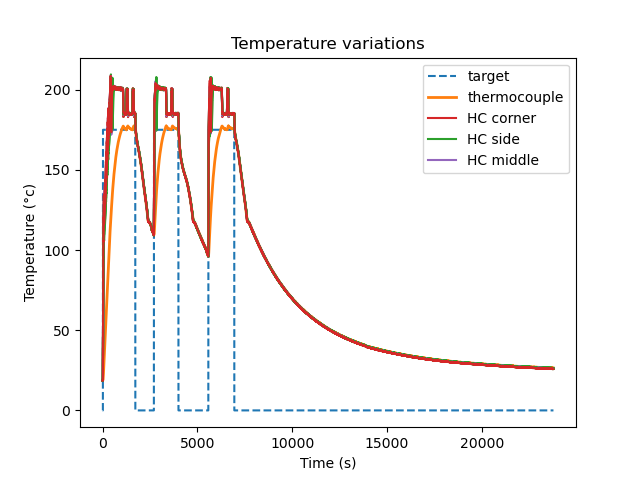

In [6]:
# Plotting the data
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

_, ax1 = plt.subplots()
labels = []
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Temperature (°c)')

ax1.plot(t, d_temp, color=color_list[0], linestyle='dashed', label='target')
ax1.plot(t, out_temp, color=color_list[1], linewidth=2, label='thermocouple')

labels = []

for i in range(16):
    if (i+1) in ct_group_side:
        if 'side' in labels:
            ax1.plot(t, ct_temp[i], color=color_list[2])
        else:
            labels.append('side')
            ax1.plot(t, ct_temp[i], color=color_list[2], label="HC side")
    elif (i+1) in ct_group_corner:
        if 'corner' in labels:
            ax1.plot(t, ct_temp[i], color=color_list[3])
        else:
            labels.append('corner')
            ax1.plot(t, ct_temp[i], color=color_list[3], label="HC corner")
    else:
        if 'middle' in labels:
            ax1.plot(t, ct_temp[i], color=color_list[4])
        else:
            labels.append('middle')
            ax1.plot(t, ct_temp[i], color=color_list[4], label="HC middle")
ax1.legend()
ax1.set_title('Temperature variations')

Text(0.5, 1.0, 'Temperature variations')

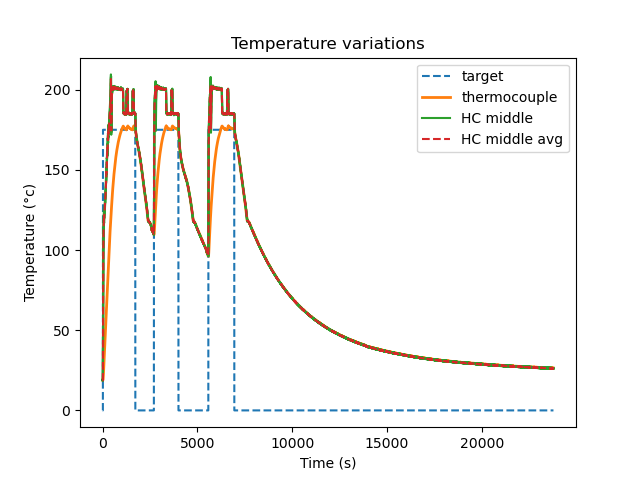

In [7]:
_, ax2 = plt.subplots()
labels = []
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Temperature (°c)')

ax2.plot(t, d_temp, color=color_list[0], linestyle='dashed', label='target')
ax2.plot(t, out_temp, color=color_list[1], linewidth=2, label='thermocouple')

labels = []

ct_middle_temp = ct_temp[ct_group_middle]
ct_avg_middle_temp = np.mean(ct_middle_temp, axis=0)

for i in range(4):
    if 'middle' in labels:
        ax2.plot(t, ct_middle_temp[i], color=color_list[2])
    else:
        labels.append('middle')
        ax2.plot(t, ct_middle_temp[i], color=color_list[2], label="HC middle")

ax2.plot(t, ct_avg_middle_temp, color=color_list[3], linestyle='dashed', label="HC middle avg")

ax2.legend()
ax2.set_title('Temperature variations')

Let's consider a second order system discretized by a zero order hold: 
$$ H(z) = \frac{a_1 z + a_0}{z^2 + b_1 z + b_0}, $$
The system can be written in its temporal form, for ARX identification:
$$ y[k] =  a_1 u[k-1] + a_0 u[k-2] - b_1 y[k-1] - b_0 y[k-2],$$

Text(0.5, 1.0, 'Time step variations')

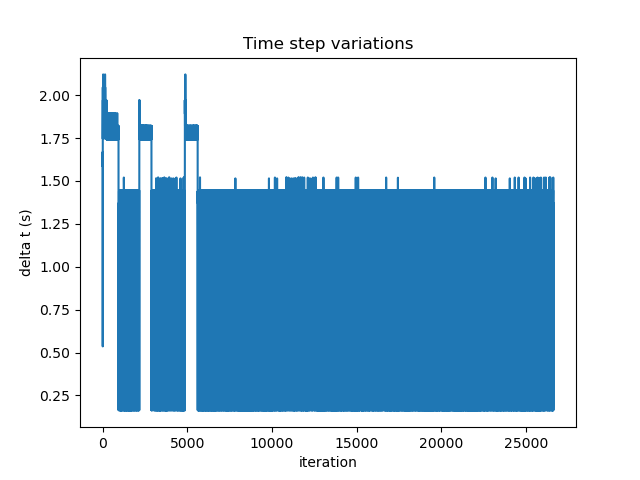

In [8]:
_, ax3 = plt.subplots()
ax3.set_xlabel('iteration') 
ax3.set_ylabel('delta t (s)')

ax3.plot(np.diff(t))
ax3.set_title('Time step variations')

For a proper identification, let's first interpolate the data on a proper time vector. The current one has uneven time steps, as shown on the plot above.

In [9]:
dt = 2
t_new = np.arange(t[0], t[-1], dt)
ct_avg_middle_temp_new = np.interp(t_new, t, ct_avg_middle_temp)
out_temp_new = np.interp(t_new, t, out_temp)

In [10]:
# identification with least square
# y = theta @ [a1,...,an, b1, ..., bn]
na = 2 # input coeff of numerator order + 1
nb = 3 # output coeff of denominator order + 1
u0 = ct_avg_middle_temp_new[0]
y0 = out_temp_new[0]
a_coeff, b_coeff, mse = lsq(na, nb, u=ct_avg_middle_temp_new, y=out_temp_new, y_init=u0*np.ones((nb-1,1)))
sysd = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)
#
a0 = a_coeff[1]
a1 = a_coeff[0]
b0 = b_coeff[1]
b1 = b_coeff[0]
sysd

TransferFunction(array([ 0.0041288 , -0.00117402]), array([ 1.       , -1.554053 ,  0.5572739]), 2)

Let's consider the state space system described in the notebook `PID_synthesis_with_space_LQ_tuning.ipynb`.

In [11]:
A = [[0,1,0], [-b0,-b1,0], [0,-dt,1]]
B = [[-a0/b0], [a1], [0]] 
C = [0,1,0]
D = 0
ctrl.ss(A,B,C,D,dt)

<LinearIOSystem:sys[3]:['u[0]']->['y[0]']>

The open loop response of the identified system, for the first heating phase.

In [12]:
t1_start = 0
t1_end = int(1726/dt)
t1 = int(2.7e3/dt)
# z0 = y0 - (a0/b0)*u0
# w0 = 0
t2_start = int(2706/dt)
t2_end = int(4000/dt)
t3_start = int(5575/dt)
t3_end = int(6950/dt)
u0_t2 = ct_avg_middle_temp_new[t2_start]
u0_t3 = ct_avg_middle_temp_new[t3_start]
# ident_sys_response = ctrl.input_output_response(sysd, t_new[:t1], ct_avg_middle_temp_new[:t1], X0=[z0,y0,w0])
_, out_temp_sim = ctrl.forced_response(sysd, t_new[:t1], ct_avg_middle_temp_new[:t1]-u0)
_, out_temp_sim_phase_2 = ctrl.forced_response(sysd, t_new[t2_start:t2_end], ct_avg_middle_temp_new[t2_start:t2_end]-u0_t2) # validation on second phase
_, out_temp_sim_phase_3 = ctrl.forced_response(sysd, t_new[t3_start:t3_end], ct_avg_middle_temp_new[t3_start:t3_end]-u0_t3) # validation on third phase

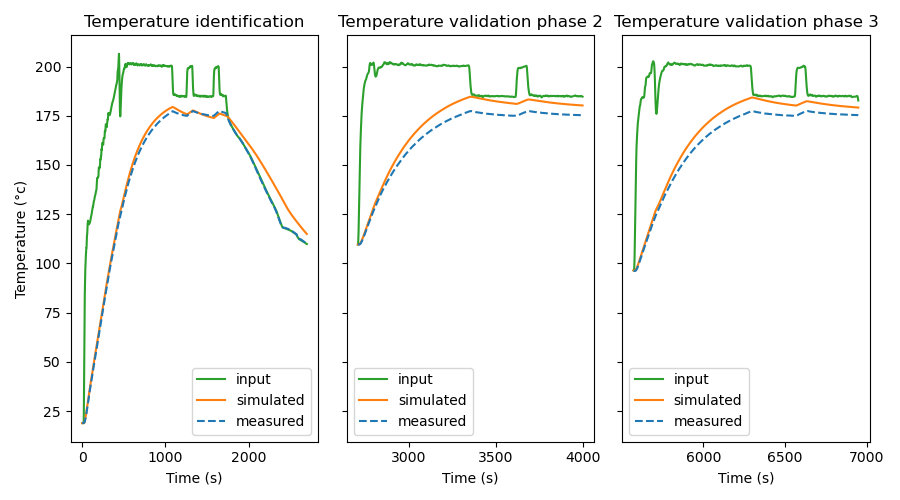

In [13]:
# Plotting the data
_, ax4 = plt.subplots(1, 3, sharey=True, figsize=(9, 5))
ax4[0].set_xlabel('Time (s)') 
ax4[1].set_xlabel('Time (s)') 
ax4[2].set_xlabel('Time (s)') 
ax4[0].set_ylabel('Temperature (°c)')

ax4[0].plot(t_new[:t1], ct_avg_middle_temp_new[:t1], color=color_list[2], label='input')
ax4[0].plot(t_new[:t1], out_temp_sim+u0, color=color_list[1], label='simulated')
ax4[0].plot(t_new[:t1], out_temp_new[:t1], color=color_list[0], linestyle='dashed', label='measured')
ax4[0].legend()
ax4[0].set_title('Temperature identification')

ax4[1].plot(t_new[t2_start:t2_end], ct_avg_middle_temp_new[t2_start:t2_end], color=color_list[2], label='input')
ax4[1].plot(t_new[t2_start:t2_end], out_temp_sim_phase_2+u0_t2, color=color_list[1], label='simulated')
ax4[1].plot(t_new[t2_start:t2_end], out_temp_new[t2_start:t2_end], color=color_list[0], linestyle='dashed', label='measured')
ax4[1].legend()
ax4[1].set_title('Temperature validation phase 2')

ax4[2].plot(t_new[t3_start:t3_end], ct_avg_middle_temp_new[t3_start:t3_end], color=color_list[2], label='input')
ax4[2].plot(t_new[t3_start:t3_end], out_temp_sim_phase_3+u0_t3, color=color_list[1], label='simulated')
ax4[2].plot(t_new[t3_start:t3_end], out_temp_new[t3_start:t3_end], color=color_list[0], linestyle='dashed', label='measured')
ax4[2].legend()
ax4[2].set_title('Temperature validation phase 3')

plt.tight_layout()

In [14]:
# Let's compute the mean square root error for each phase simulated
mse_ph1 = np.sqrt( np.mean((out_temp_sim[t1_start:t1_end]+u0 - out_temp_new[t1_start:t1_end])**2) )
mse_ph2 = np.sqrt( np.mean((out_temp_sim_phase_2+u0_t2 - out_temp_new[t2_start:t2_end])**2) )
mse_ph3 = np.sqrt( np.mean((out_temp_sim_phase_3+u0_t3 - out_temp_new[t3_start:t3_end])**2) )
print("RMSE ph1 (ident): {:.2f}°c\nRMSE ph2: {:.2f}°c\nRMSE ph3: {:.2f}°c".format(mse_ph1, mse_ph2, mse_ph3))

RMSE ph1 (ident): 1.99°c
RMSE ph2: 5.75°c
RMSE ph3: 5.30°c


The identification could probably be improved by only looking at the actively heating phase, since the cooling phase suffers different conditions.

In [15]:
# identification on the active part, with null initial conditions
idx_first_heating_phase_end = t1_end*dt
t_ident = t_new[:idx_first_heating_phase_end]
a_coeff_2, b_coeff_2, mse = lsq(na, nb, u=ct_avg_middle_temp_new[:idx_first_heating_phase_end]-u0, y=out_temp_new[:idx_first_heating_phase_end]-y0, y_init=np.zeros((nb-1,1)))
sysd_2 = ctrl.TransferFunction(a_coeff_2, np.insert(b_coeff_2, 0, 1), dt)
#
a0 = a_coeff_2[1]
a1 = a_coeff_2[0]
b0 = b_coeff_2[1]
b1 = b_coeff_2[0]
sysd_2

TransferFunction(array([0.00150926, 0.00065772]), array([ 1.        , -1.67713751,  0.67955736]), 2)

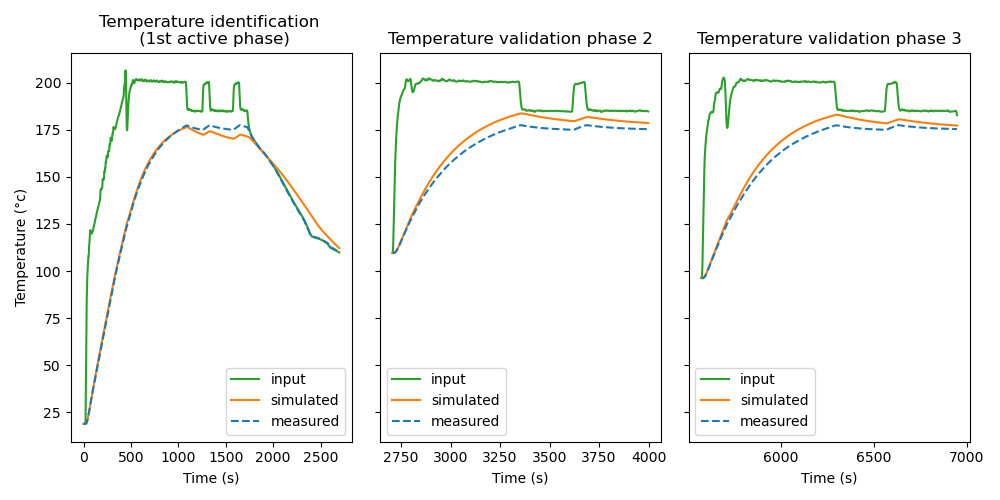

In [16]:
_, out_temp_sim_idph1 = ctrl.forced_response(sysd_2, t_new[:t1], ct_avg_middle_temp_new[:t1]-u0)
_, out_temp_sim_idph1_phase_2 = ctrl.forced_response(sysd_2, t_new[t2_start:t2_end], ct_avg_middle_temp_new[t2_start:t2_end]-u0_t2) # validation on second phase
_, out_temp_sim_idph1_phase_3 = ctrl.forced_response(sysd_2, t_new[t3_start:t3_end], ct_avg_middle_temp_new[t3_start:t3_end]-u0_t3) # validation on third phase

_, ax5 = plt.subplots(1, 3, sharey=True, figsize=(10, 5))
ax5[0].set_xlabel('Time (s)') 
ax5[1].set_xlabel('Time (s)') 
ax5[2].set_xlabel('Time (s)') 
ax5[0].set_ylabel('Temperature (°c)')

ax5[0].plot(t_new[:t1], ct_avg_middle_temp_new[:t1], color=color_list[2], label='input')
ax5[0].plot(t_new[:t1], out_temp_sim_idph1+u0, color=color_list[1], label='simulated')
ax5[0].plot(t_new[:t1], out_temp_new[:t1], color=color_list[0], linestyle='dashed', label='measured')
ax5[0].legend()
ax5[0].set_title('Temperature identification \n (1st active phase)')

ax5[1].plot(t_new[t2_start:t2_end], ct_avg_middle_temp_new[t2_start:t2_end], color=color_list[2], label='input')
ax5[1].plot(t_new[t2_start:t2_end], out_temp_sim_idph1_phase_2+u0_t2, color=color_list[1], label='simulated')
ax5[1].plot(t_new[t2_start:t2_end], out_temp_new[t2_start:t2_end], color=color_list[0], linestyle='dashed', label='measured')
ax5[1].legend()
ax5[1].set_title('Temperature validation phase 2')

ax5[2].plot(t_new[t3_start:t3_end], ct_avg_middle_temp_new[t3_start:t3_end], color=color_list[2], label='input')
ax5[2].plot(t_new[t3_start:t3_end], out_temp_sim_idph1_phase_3+u0_t3, color=color_list[1], label='simulated')
ax5[2].plot(t_new[t3_start:t3_end], out_temp_new[t3_start:t3_end], color=color_list[0], linestyle='dashed', label='measured')
ax5[2].legend()
ax5[2].set_title('Temperature validation phase 3')

plt.tight_layout()

In [17]:
# Let's compute the mean square root error for each phase simulated
mse_ph1 = np.sqrt( np.mean((out_temp_sim_idph1[t1_start:t1_end]+u0 - out_temp_new[t1_start:t1_end])**2) )
mse_ph2 = np.sqrt( np.mean((out_temp_sim_idph1_phase_2+u0_t2 - out_temp_new[t2_start:t2_end])**2) )
mse_ph3 = np.sqrt( np.mean((out_temp_sim_idph1_phase_3+u0_t3 - out_temp_new[t3_start:t3_end])**2) )
print("RMSE ph1 (ident): {:.2f}°c\nRMSE ph2: {:.2f}°c\nRMSE ph3: {:.2f}°c".format(mse_ph1, mse_ph2, mse_ph3))

RMSE ph1 (ident): 2.36°c
RMSE ph2: 4.77°c
RMSE ph3: 4.19°c


The identification only on the first actively heating phase improved greatly the prediction error on the identified phase, but also on the other two phases used for validation.

It seems that the model parameters differ the first time the system is heated compared to the rest of the time. Let's identify the parameters on the first validation set, and compare the simulated responses.

In [18]:
# identification on the second active part, with null initial conditions
t_ident = t_new[t2_start:t2_end]
y0_t2 = out_temp_new[t2_start]
a_coeff_3, b_coeff_3, mse = lsq(na, nb, u=ct_avg_middle_temp_new[t2_start:t2_end]-u0_t2, y=out_temp_new[t2_start:t2_end]-y0_t2, y_init=np.zeros((nb-1,1)))
sysd_3 = ctrl.TransferFunction(a_coeff_3, np.insert(b_coeff_3, 0, 1), dt)
#
a0 = a_coeff_3[1]
a1 = a_coeff_3[0]
b0 = b_coeff_3[1]
b1 = b_coeff_3[0]
sysd_3

TransferFunction(array([-0.0095561 ,  0.01615933]), array([ 1.        , -0.89907224, -0.0930761 ]), 2)

This is the model that will be used for the control tuning of the bottom stack.

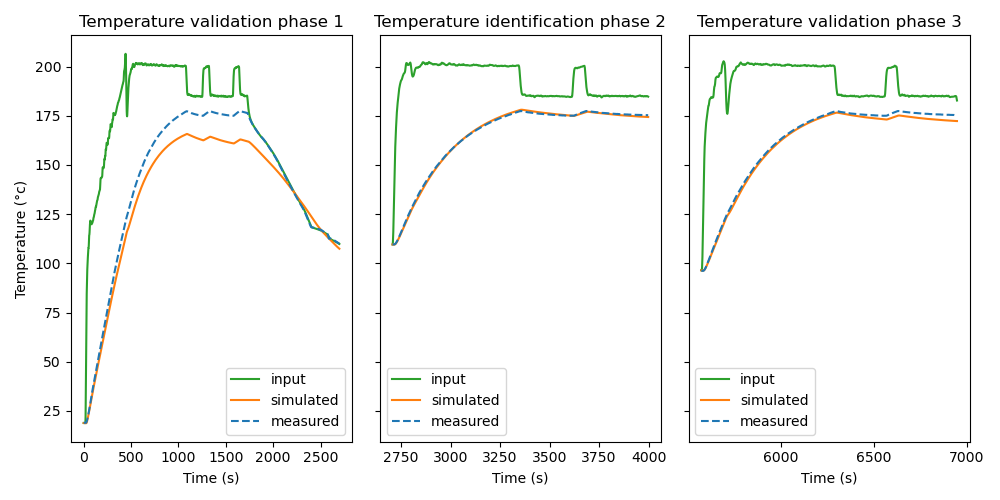

In [19]:
_, out_temp_sim_idph2 = ctrl.forced_response(sysd_3, t_new[:t1], ct_avg_middle_temp_new[:t1]-u0)
_, out_temp_sim_idph2_phase_2 = ctrl.forced_response(sysd_3, t_new[t2_start:t2_end], ct_avg_middle_temp_new[t2_start:t2_end]-u0_t2) # validation on second phase
_, out_temp_sim_idph2_phase_3 = ctrl.forced_response(sysd_3, t_new[t3_start:t3_end], ct_avg_middle_temp_new[t3_start:t3_end]-u0_t3) # validation on third phase

_, ax6 = plt.subplots(1, 3, sharey=True, figsize=(10, 5))
ax6[0].set_xlabel('Time (s)') 
ax6[1].set_xlabel('Time (s)') 
ax6[2].set_xlabel('Time (s)') 
ax6[0].set_ylabel('Temperature (°c)')

ax6[0].plot(t_new[:t1], ct_avg_middle_temp_new[:t1], color=color_list[2], label='input')
ax6[0].plot(t_new[:t1], out_temp_sim_idph2+u0, color=color_list[1], label='simulated')
ax6[0].plot(t_new[:t1], out_temp_new[:t1], color=color_list[0], linestyle='dashed', label='measured')
ax6[0].legend()
ax6[0].set_title('Temperature validation phase 1')

ax6[1].plot(t_new[t2_start:t2_end], ct_avg_middle_temp_new[t2_start:t2_end], color=color_list[2], label='input')
ax6[1].plot(t_new[t2_start:t2_end], out_temp_sim_idph2_phase_2+u0_t2, color=color_list[1], label='simulated')
ax6[1].plot(t_new[t2_start:t2_end], out_temp_new[t2_start:t2_end], color=color_list[0], linestyle='dashed', label='measured')
ax6[1].legend()
ax6[1].set_title('Temperature identification phase 2')

ax6[2].plot(t_new[t3_start:t3_end], ct_avg_middle_temp_new[t3_start:t3_end], color=color_list[2], label='input')
ax6[2].plot(t_new[t3_start:t3_end], out_temp_sim_idph2_phase_3+u0_t3, color=color_list[1], label='simulated')
ax6[2].plot(t_new[t3_start:t3_end], out_temp_new[t3_start:t3_end], color=color_list[0], linestyle='dashed', label='measured')
ax6[2].legend()
ax6[2].set_title('Temperature validation phase 3')

plt.tight_layout()

In [20]:
# Let's compute the mean square root error for each phase simulated
mse_ph1 = np.sqrt( np.mean((out_temp_sim_idph2[t1_start:t1_end]+u0 - out_temp_new[t1_start:t1_end])**2) )
mse_ph2 = np.sqrt( np.mean((out_temp_sim_idph2_phase_2+u0_t2 - out_temp_new[t2_start:t2_end])**2) )
mse_ph3 = np.sqrt( np.mean((out_temp_sim_idph2_phase_3+u0_t3 - out_temp_new[t3_start:t3_end])**2) )
print("RMSE ph1 (ident): {:.2f}°c\nRMSE ph2: {:.2f}°c\nRMSE ph3: {:.2f}°c".format(mse_ph1, mse_ph2, mse_ph3))

RMSE ph1 (ident): 10.43°c
RMSE ph2: 0.59°c
RMSE ph3: 1.60°c


The identification only on the second actively heating phase improved greatly the prediction error on the identified phase 2, and also on the third phase. However, the first phase was highly deteriorated, which confort the idea that the parameters vary when the system was already heated.

### Validation on the data from January 17th, 2024

To see of the observation made on 3 runs are representative of the global behaviour of the press, another data set with more runs is studied in the following part.

In [21]:
# clearing all variables
all_vars = list(globals().keys())
# Exclude variable names starting with underscores or those from modules
vars_to_remove = [var for var in all_vars if not var.startswith('_') and not var.startswith('sysd')] # exception for internal ipython variables, and identified models
# Clear each variable from the global namespace
for var_name in vars_to_remove:
    del globals()[var_name]

In [22]:
%matplotlib widget
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import control as ctrl

from utils import read_pv3_heatdata_txt, get_settling_time

2024-03-13 10:05:40,855 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-03-13 10:05:40,858 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [23]:
# Reading the data from the PV3 files
file_path = "data/experimental/24_01_17/all_bottom.txt" # concatenation of "Bottom Heat Controller worker.txt" files

data, headers = read_pv3_heatdata_txt(file_path)
t = (data['Time'] - data['Time'][0]) / 1e3 # conversion to seconds 
d_temp = np.array(data['Target']) # desired temperature
out_temp = np.array(data['Thermocouple']) # output temperature measured with thermocouple
ct_temp = []
for i in range(16):
    name = "RC" + str(i+1)
    ct_temp.append(data[name])
ct_temp = np.array(ct_temp)
cartridges_avg_temp = np.mean(ct_temp, axis=0)

# when the data was concatenated, all the time vector were not sorted properly, the data need to be rearranged
sorted_indices = np.argsort(t)
t = t[sorted_indices]
t = t - t[0]
d_temp = d_temp[sorted_indices]
out_temp = out_temp[sorted_indices]
ct_temp = ct_temp[:,sorted_indices]
cartridges_avg_temp = cartridges_avg_temp[sorted_indices]

Text(0.5, 1.0, 'Temperature variations')

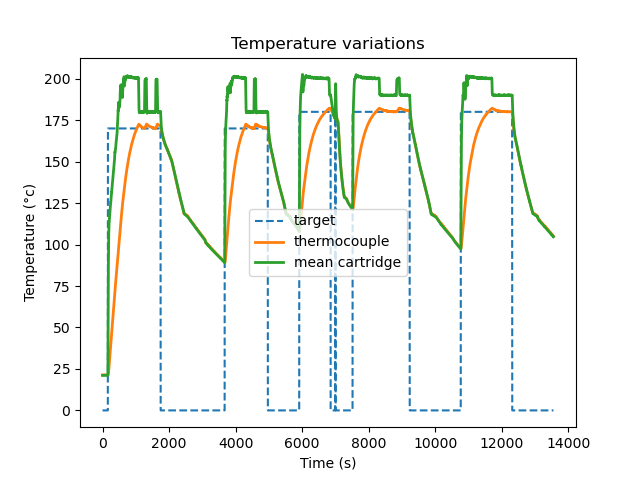

In [24]:
# Plotting the data
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

_, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Temperature (°c)')

ax1.plot(t, d_temp, color=color_list[0], linestyle='dashed', label='target')
ax1.plot(t, out_temp, color=color_list[1], linewidth=2, label='thermocouple')
ax1.plot(t, cartridges_avg_temp, color=color_list[2], linewidth=2, label='mean cartridge')

ax1.legend()
ax1.set_title('Temperature variations')

In [25]:
dt = 2
t_old = t.copy()
t = np.arange(t[0], t[-1], dt)
cartridges_avg_temp = np.interp(t, t_old, cartridges_avg_temp)
out_temp = np.interp(t, t_old, out_temp)
d_temp = np.interp(t, t_old, d_temp)

In [26]:
# getting the indexes of the heating and cooling phases
rising_edges = [i for i, val in enumerate(np.diff(np.sign(d_temp))) if val > 0]
falling_edges = [i-1 for i, val in enumerate(np.diff(np.sign(d_temp))) if val < 0]
# some heating phase might be incomplete and will be ignored
unfinished_heating_phase = []
for i, edge_idx in enumerate(rising_edges):
    if falling_edges[i] - edge_idx < 500:
        unfinished_heating_phase.append(i)

rising_edges = [val for idx, val in enumerate(rising_edges) if idx not in unfinished_heating_phase]
falling_edges = [val for idx, val in enumerate(falling_edges) if idx not in unfinished_heating_phase]
# _, ax2 = plt.subplots()
# ax2.plot(d_temp)
# ax2.plot(rising_edges, d_temp[rising_edges], '*')
# ax2.plot(falling_edges, d_temp[falling_edges], '*')

Let's compare the previously indentified model to the current experimental data.

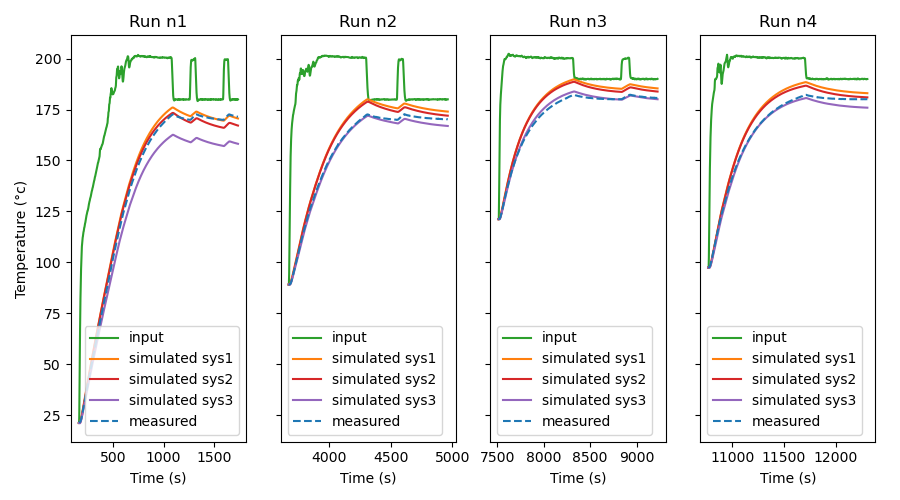

In [27]:
nb_phase = len(rising_edges)
rmse = np.zeros((nb_phase, 3))
_, ax3 = plt.subplots(1, nb_phase, sharey=True, figsize=(9, 5))
for i in range(nb_phase):
    ax3[i].set_xlabel('Time (s)') 
    if i == 0:
        ax3[i].set_ylabel('Temperature (°c)')

    u0 = cartridges_avg_temp[rising_edges[i]-1]
    _, out_temp_sim_sys1 = ctrl.forced_response(sysd, t[rising_edges[i]:falling_edges[i]], cartridges_avg_temp[rising_edges[i]:falling_edges[i]]-u0)
    _, out_temp_sim_sys2 = ctrl.forced_response(sysd_2, t[rising_edges[i]:falling_edges[i]], cartridges_avg_temp[rising_edges[i]:falling_edges[i]]-u0)
    _, out_temp_sim_sys3 = ctrl.forced_response(sysd_3, t[rising_edges[i]:falling_edges[i]], cartridges_avg_temp[rising_edges[i]:falling_edges[i]]-u0)

    ax3[i].plot(t[rising_edges[i]:falling_edges[i]], cartridges_avg_temp[rising_edges[i]:falling_edges[i]], color=color_list[2], label='input')
    ax3[i].plot(t[rising_edges[i]:falling_edges[i]], out_temp_sim_sys1+u0, color=color_list[1], label='simulated sys1')
    ax3[i].plot(t[rising_edges[i]:falling_edges[i]], out_temp_sim_sys2+u0, color=color_list[3], label='simulated sys2')
    ax3[i].plot(t[rising_edges[i]:falling_edges[i]], out_temp_sim_sys3+u0, color=color_list[4], label='simulated sys3')
    ax3[i].plot(t[rising_edges[i]:falling_edges[i]], out_temp[rising_edges[i]:falling_edges[i]], color=color_list[0], linestyle='dashed', label='measured')
    ax3[i].legend()
    ax3[i].set_title('Run n' + str(i+1))

    rmse[i,0] = np.sqrt( np.mean((out_temp_sim_sys1+u0 - out_temp[rising_edges[i]:falling_edges[i]])**2) )
    rmse[i,1] = np.sqrt( np.mean((out_temp_sim_sys2+u0 - out_temp[rising_edges[i]:falling_edges[i]])**2) )
    rmse[i,2] = np.sqrt( np.mean((out_temp_sim_sys3+u0 - out_temp[rising_edges[i]:falling_edges[i]])**2) )

plt.tight_layout()

In [28]:
rmse_df = pd.DataFrame(rmse.T, columns=['run 1','run 2','run 3','run 4'], index=['sys 1', 'sys 2', 'sys 3'])
display(Markdown("### Root Mean Square error of the simulated system response according the each heating phase (°c)"))
rmse_df = rmse_df.style.format('{:.2f}').map(lambda x: f'{'font-weight: bold'}; {'background-color: green'}' if x < 3 else '')
rmse_df

### Root Mean Square error of the simulated system response according the each heating phase (°c)

The results obtained with the data from the 29th of Januray are conforted by the validation on the data set from the 17th of Januray.

The first two parameters set identified fit better the first heating phase, while the third parameter set fits better the other heating phase. One explanation could come from the model used that is an oversimplication of the real heat equation (neglecting 3D behaviour and specificities due the inhomogenous parts coming from the cooling system notably).

We could consider two parameters sets, or try to preheat the system to avoid having a different behaviour on the first run (phase).

The errors could also come from different activation in all cartridges, having them all with the same temperature might improve the adequacy with the second order model.

### Identification of the upper stack

In [29]:
from utils import identify_PV3_stack_2nd_order_model

stack = "Top"
file_path = "data/experimental/24_01_29/10_32_19/heatData/"+stack+" Heat Controller worker.txt"
top_stack_a, top_stack_b, top_stack_mse = identify_PV3_stack_2nd_order_model(file_path, dt=dt, min_steady_state_time=500)

In [30]:
# top stack identified models
sys_top_list = []
for a_coeffs, b_coeffs in zip(top_stack_a, top_stack_b):
    sys_top_list.append(ctrl.TransferFunction(a_coeffs, np.insert(b_coeffs, 0, 1), dt))

In [31]:
# validation set
from utils import concatenate_pv3_heatdata
import os

validation_folder = "data/experimental/24_01_17"
if not os.path.exists(validation_folder + "/all_"+stack+".txt"):
    concatenate_pv3_heatdata(validation_folder, validation_folder + "/all_"+stack+".txt", heatdata_filename=stack+" Heat Controller worker.txt")

In [32]:
# Reading the data from the PV3 files
file_path = "data/experimental/24_01_17/all_"+stack+".txt" # concatenation of "Top Heat Controller worker.txt" files

data, headers = read_pv3_heatdata_txt(file_path)
t = (data['Time'] - data['Time'][0]) / 1e3 # conversion to seconds 
d_temp = np.array(data['Target']) # desired temperature
out_temp = np.array(data['Thermocouple']) # output temperature measured with thermocouple
ct_temp = []
cart_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]

for cart_name in cart_names:
    ct_temp.append(data[cart_name])
ct_temp = np.array(ct_temp)
# only the 4 middle cartridge temperatures are used for identification
ct_middle_group = [6,7,10,11]
ct_avg_middle_temp = np.mean(ct_temp[ct_middle_group,:], axis=0)
# when the data was concatenated, all the time vector were not sorted properly, the data need to be rearranged
sorted_indices = np.argsort(t)
t = t[sorted_indices]
t = t - t[0]
d_temp = d_temp[sorted_indices]
out_temp = out_temp[sorted_indices]
ct_temp = ct_temp[:,sorted_indices]
ct_avg_middle_temp = ct_avg_middle_temp[sorted_indices]

Text(0.5, 1.0, 'Temperature variations')

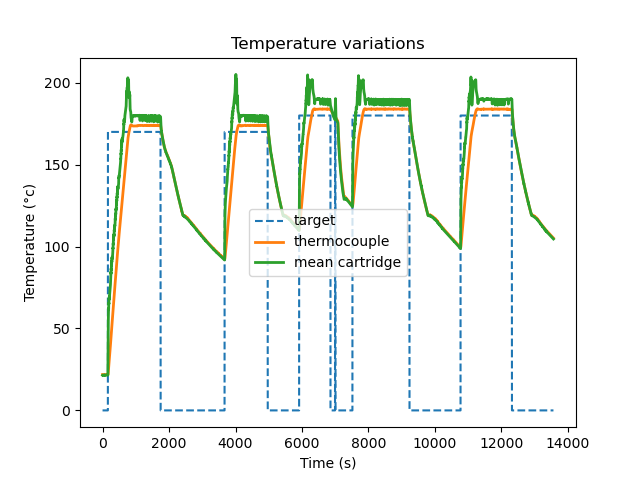

In [33]:
# plotting the data
_, ax4 = plt.subplots()
ax4.set_xlabel('Time (s)') 
ax4.set_ylabel('Temperature (°c)')

ax4.plot(t, d_temp, color=color_list[0], linestyle='dashed', label='target')
ax4.plot(t, out_temp, color=color_list[1], linewidth=2, label='thermocouple')
ax4.plot(t, ct_avg_middle_temp, color=color_list[2], linewidth=2, label='mean cartridge')

ax4.legend()
ax4.set_title('Temperature variations')

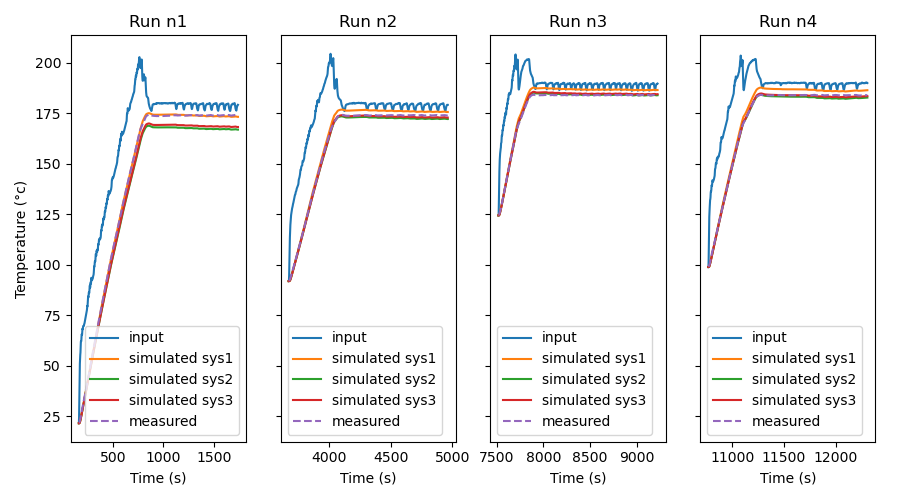

In [34]:
## interpolation
dt = 2
t_old = t.copy()
t = np.arange(t[0], t[-1], dt)
ct_avg_middle_temp = np.interp(t, t_old, ct_avg_middle_temp)
out_temp = np.interp(t, t_old, out_temp)
d_temp = np.interp(t, t_old, d_temp)
## getting the indexes of the heating and cooling phases
rising_edges = [i for i, val in enumerate(np.diff(np.sign(d_temp))) if val > 0]
falling_edges = [i-1 for i, val in enumerate(np.diff(np.sign(d_temp))) if val < 0]
# some heating phase might be incomplete and will be ignored
unfinished_heating_phase = []
for i, edge_idx in enumerate(rising_edges):
    if falling_edges[i] - edge_idx < 500:
        unfinished_heating_phase.append(i)
rising_edges = [val for idx, val in enumerate(rising_edges) if idx not in unfinished_heating_phase]
falling_edges = [val for idx, val in enumerate(falling_edges) if idx not in unfinished_heating_phase]
## plotting
nb_phase = len(rising_edges)
rmse = np.zeros((nb_phase, len(sys_top_list)))
_, ax5 = plt.subplots(1, nb_phase, sharey=True, figsize=(9, 5))
for i in range(nb_phase):
    ax5[i].set_xlabel('Time (s)') 
    if i == 0:
        ax5[i].set_ylabel('Temperature (°c)')
    
    ax5[i].plot(t[rising_edges[i]:falling_edges[i]], ct_avg_middle_temp[rising_edges[i]:falling_edges[i]], color=color_list[0], label='input')

    u0 = ct_avg_middle_temp[rising_edges[i]-1]
    for j, sys_top_stack in enumerate(sys_top_list):
        _, out_temp_sim_sys = ctrl.forced_response(sys_top_stack, t[rising_edges[i]:falling_edges[i]], ct_avg_middle_temp[rising_edges[i]:falling_edges[i]]-u0)
        rmse[i,j] = np.sqrt( np.mean((out_temp_sim_sys+u0 - out_temp[rising_edges[i]:falling_edges[i]])**2) )
        ax5[i].plot(t[rising_edges[i]:falling_edges[i]], out_temp_sim_sys+u0, color=color_list[j+1], label='simulated sys' + str(j+1))

    ax5[i].plot(t[rising_edges[i]:falling_edges[i]], out_temp[rising_edges[i]:falling_edges[i]], color=color_list[j+2], linestyle='dashed', label='measured')
    ax5[i].legend()
    ax5[i].set_title('Run n' + str(i+1))

plt.tight_layout()

In [35]:
rmse_df = pd.DataFrame(rmse.T, columns=['run 1','run 2','run 3','run 4'], index=['sys 1', 'sys 2', 'sys 3'])
display(Markdown("### Root Mean Square error of the simulated system response according the each heating phase (°c)"))
rmse_df = rmse_df.style.format('{:.2f}').map(lambda x: f'{'font-weight: bold'}; {'background-color: green'}' if x < 3 else '')
rmse_df

### Root Mean Square error of the simulated system response according the each heating phase (°c)

For the top stack the best fit seem to be reached for the last model.

In [36]:
sys_top_list[-1]

TransferFunction(array([0.00380759, 0.00794472]), array([ 1.        , -1.14437971,  0.15697371]), 2)

### Full State Feedback control

In this section, a full state feedback control is tuned using an optimized LQR method with a PSO algorithm.

In [37]:
from utils import simulate_full_state_feedback_closed_loop
from tqdm.notebook import tqdm

In [38]:
import pyswarms as ps
from typing import Callable

def cost_function_DLQR(QR, state_space, max_desired_cmd):
    """
    Cost function for Particle Swarm Optimization (PSO) to tune DLQR controller.

    Args:
        QR (np.array): Concatenation of Q and R matrices for LQR tuning.
        state_space (StateSpace): Augmented state-space system with additional integral action.
        max_desired_cmd (float): Normalized peak value of the command relative to a unitary setpoint.

    Returns:
        J (list): List of cost values for each set of Q and R parameters.
    """
    J = []
    A = state_space.A
    B = state_space.B
    C = state_space.C
    D = state_space.D
    dt = state_space.dt
    # Extract Q and R matrices from the optimization variable QR
    Q_size = np.shape(A)[0]
    R_size = np.shape(B)
    Q_list = QR[:,:Q_size]
    R_list = QR[:,Q_size:]
    for Q_param, R_param in zip(Q_list, R_list):
        Q = np.diag(Q_param).squeeze()
        R = np.diag(R_param).squeeze()
        # Compute the feedback gain matrix K using DLQR
        K, _, _ = ctrl.dlqr(A, B, Q, R)
        # Full state feedback closed-loop output
        ss_cl = ctrl.StateSpace(A - B@K, [[0], [0], [dt]], C, D, dt)
        # Full state feedback closed-loop command
        ss_cl_u = ctrl.StateSpace(A - B@K, [[0], [0], [dt]], -K, D, dt) # this returns the command u
        # Computing the settling time and max cmd value
        try:
            settling_time = ctrl.step_info(ss_cl, SettlingTimeThreshold=0.05)['SettlingTime'] # this might fails if the response is too slow
        except:
            settling_time = 4000
        try:
            max_cmd_val = ctrl.step_info(ss_cl_u)['Peak']
        except:
            t = np.arange(0, 500, dt)
            _, cmd_vals = ctrl.step_response(ss_cl_u, t)
            max_cmd_val = max(cmd_vals)
        # Define the cost function components
        cost_command_response = max_cmd_val - max_desired_cmd
        if cost_command_response < 0:
            cost_command_response *= settling_time/2 # when the command is lower than the limit provided, the benefit is low
        else:
            cost_command_response *= 4000 # when the command is higher than the limit provided, the penalization is very strong
        J.append(settling_time + cost_command_response)
    return J

def tune_full_state_feedback_LQR(sys:(ctrl.TransferFunction or ctrl.StateSpace), cost_func:Callable, u_lim:(float or None)=None, verbose:bool=True):
    """
    Tune the full state feedback control using Linear Quadratic Regulator (LQR) to achieve quick response,
    while optionally limiting the control signal.
    If a state space system is provided, then the second state should be the output.

    Args:
        sys (TransferFunction or StateSpace): Second-order system model.
        u_lim (float or None): Normalized peak value of the command relative to a unitary setpoint.
                              If None, no limitation is set on the control signal.
        verbose (bool): If True, display optimization progress; default is True.
    Returns:
        K (np.array): The tuned state feedback gain matrix.
        Q_opt (np.array): Optimized state weight matrix Q for LQR.
        R_opt (np.array): Optimized input weight matrix R for LQR.
    """
    # Check the system type
    if isinstance(sys, ctrl.TransferFunction):
        # Convert to State Space system
        a_coeff = np.array(sys.num).squeeze()
        b_coeff = np.array(sys.den).squeeze()
        A = np.array([[0,1], [-b_coeff[2],-b_coeff[1]]])
        B = np.array([[-a_coeff[1]/b_coeff[2]], [a_coeff[0]]])
        C = np.array([0, 1])
        D = np.array(0)
    elif isinstance(sys, ctrl.StateSpace):
        # No conversion required
        A = sys.A
        B = sys.B
        C = sys.C
        D = sys.D.squeeze()
        pass
    else:
        raise ValueError("Unsupported system type: {}".format(type(sys)))
    # Check if the system is discrete
    if not ctrl.isdtime(sys):
        raise ValueError("The system should be discrete.")
    else:
        dt = sys.dt
    # State space system augmentation for additional integral action
    A = np.vstack((np.hstack((A, [[0],[0]])), [0,-dt,1]))
    B = np.vstack((B,0))
    C = np.hstack((C,0))
    sys_aug = ctrl.ss(A,B,C,D,dt)
    # LQR tuning using Particle Swarm Optimization (PSO)
    dim = np.shape(A)[0] + np.shape(B)[1] # R is a scalar
    max_bound = 10000 * np.ones(dim) 
    min_bound = 0 * np.ones(dim)
    bounds = (min_bound, max_bound)
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    t, y = ctrl.step_response(sys,T=2000)
    ref_set = t[np.where(y >= 0.95*y[-1])[0][0]]
    kwargs={'state_space':sys_aug, 'max_desired_cmd': u_lim, 'openloop_set_time':ref_set}
    optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=dim, ftol = 1e-3, ftol_iter = 30, options=options, bounds=bounds)
    cost, QR = optimizer.optimize(cost_func, 100, n_processes=10, verbose=verbose,**kwargs)
    # Extract optimized state (Q) and input (R) weight matrices
    Q_opt = np.diag(QR[:np.shape(A)[0]]).squeeze()
    R_opt = np.diag(QR[np.shape(A)[0]:]).squeeze()
    # Calculate the optimal state feedback gain matrix K
    K_opt, S_opt, E_opt = ctrl.dlqr(A, B, Q_opt, R_opt)

    return K_opt, Q_opt, R_opt, cost

In [39]:
# Same optimization with arx simulation for the dynamic behaviour integrating saturation of the command
from utils import simulate_full_state_feedback_arx_closed_loop 

def cost_function_DLQR_ARX(QR, state_space, max_desired_cmd, openloop_set_time):
    """
    Cost function for Particle Swarm Optimization (PSO) to tune DLQR controller.

    Args:
        QR (np.array): Concatenation of Q and R matrices for LQR tuning.
        state_space (StateSpace): Augmented state-space system with additional integral action.
        max_desired_cmd (float): Normalized peak value of the command relative to a unitary setpoint.
        openloop_set_time (float): Open loop 5% set time.

    Returns:
        J (list): List of cost values for each set of Q and R parameters.
    """
    J = []
    A = state_space.A
    B = state_space.B
    C = state_space.C
    D = state_space.D
    dt = state_space.dt
    # tf conversion for the non augmented system
    tf_sys = ctrl.ss2tf(A[:2,:2], B[:2,0], C[0,:2], D, dt)
    a_coeff = np.array(tf_sys.num).squeeze()
    b_coeff = np.array(tf_sys.den).squeeze()[1:]
    # Extract Q and R matrices from the optimization variable QR
    Q_size = np.shape(A)[0]
    R_size = np.shape(B)
    Q_list = QR[:,:Q_size]
    R_list = QR[:,Q_size:]
    t_sim = 2000
    target_temperature = 180
    init_temperature = 100
    for Q_param, R_param in zip(Q_list, R_list):
        Q = np.diag(Q_param).squeeze()
        R = np.diag(R_param).squeeze()
        # Compute the feedback gain matrix K using DLQR
        K, _, _ = ctrl.dlqr(A, B, Q, R)
        # simulate system using ARX representation
        t, y, u = simulate_full_state_feedback_arx_closed_loop(tf_sys, K, target_temperature, t_sim, np.array([0, 250]), init_temperature, init_temperature, True, True)
        err = target_temperature - y
        final_err = np.mean(err[-10:])
        t_err_last_thresh = t[np.where(np.abs(err) >= 0.05*target_temperature)[0][-1]] # 5% settling time
        derr = np.diff(err, axis=0)
        max_y_norm = np.max(y)/target_temperature
        # try:
        #     t = t.reshape((-1,1))
        #     derr = np.gradient(y)
        # except:
        #     print("y: {}:".format(y.shape))
        #     print("t: {}:".format(t.shape))
        #     derr = np.gradient(y, t)
        t_err_stable = t[np.where(np.abs(derr) >= 0.05*np.abs(np.mean(derr)))[0][-1]] # 5% stability
        # Define the cost function components minimize response time and K gains
        J.append(t_err_last_thresh/(openloop_set_time) + t_err_stable/(1.1*openloop_set_time) + max_y_norm) # np.sum(np.absolute(K))/3)
    return J

### Bottom stack full state feedback control

In [40]:
sysd_3

TransferFunction(array([-0.0095561 ,  0.01615933]), array([ 1.        , -0.89907224, -0.0930761 ]), 2)

In [43]:
limit_cartridges_temp = 250
normalized_max_u = limit_cartridges_temp/max(d_temp)
K, Q_opt, R_opt, cost = tune_full_state_feedback_LQR(sysd_3, cost_function_DLQR_ARX, normalized_max_u)

2024-03-13 10:08:10,022 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:  30%|███       |30/100, best_cost=1.8
2024-03-13 10:08:34,998 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.7977038705064854, best pos: [5972.55173409  924.66398138 4720.33406998  248.17224954]


In [72]:
max(d_temp)

180.0

In [44]:
print("Q_opt: {}".format(Q_opt))
print("r_opt: {}".format(R_opt))
print("         Found K matrix corrector gain         ")
print("-----------------------------------------------")
print("K_opt: {}".format(K))
print("-----------------------------------------------")

Q_opt: [[5972.55173409    0.            0.        ]
 [   0.          924.66398138    0.        ]
 [   0.            0.         4720.33406998]]
r_opt: 248.172249540717
         Found K matrix corrector gain         
-----------------------------------------------
K_opt: [[ 4.45955443 54.72363433 -2.88405795]]
-----------------------------------------------


Text(0.5, 1.0, 'Unit step response, t5% = 478.0s, umax = 2.543')

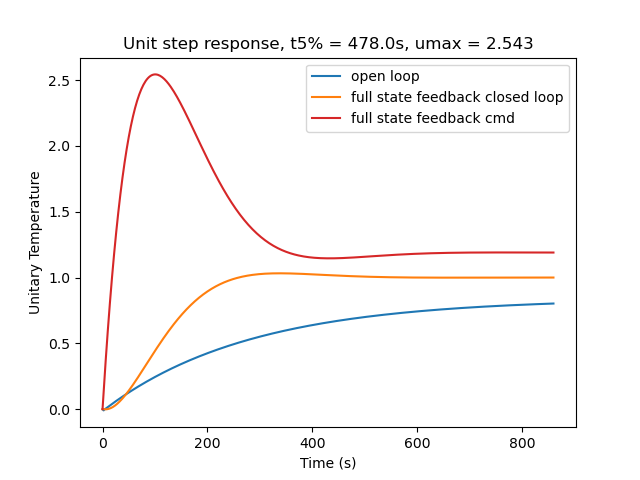

In [153]:
t, y_cl, u_cl, y_ol, set_time = simulate_full_state_feedback_closed_loop(sysd_3, K, is_integral_action=True)
u_max = np.max(u_cl)
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Unitary Temperature')
ax.plot(t, y_ol, color="tab:blue", label='open loop')
ax.plot(t, y_cl, color="tab:orange", label='full state feedback closed loop')
ax.plot(t, u_cl, color="tab:red", label='full state feedback cmd')
ax.legend()
ax.set_title("Unit step response, t5% = {:.1f}s, umax = {:.3f}".format(set_time, u_max))

Example of differents run results.

K_opt: [[-1.36259538,  3.92184185, -0.01656831]] u_max = 1.55

K_opt: [[-1.7688604   5.00454811 -0.01795611]] : u_max = 1.45 (best cost: 839)

K_opt: [[-1.19843865  3.42813466 -0.01256813]] : u_max = 1.41 (best cost: 668)

K_opt: [[-0.99947254  2.87360726 -0.01069468]] : u_max = 1.4 (best_cost: 607)

K_opt: [[-1.07878455  3.08633616 -0.01126393]] : u_max < 1.4 (best cost: 605)

K_opt: [[-1.140718    3.27256449 -0.01097936]] : u_max = 1.35 (best cost: 645)

K_opt: [-1.40858406,  4.03174207, -0.01573826] : u_max = 1.49, t5% = 613s

Let's run multiple time the PSO optimization to keep the best compromise betweem the command signal and the settling time. (Uncomment the next cell to rerun the optimization based on tjhe simulated step response, it might take several hours.)

In [75]:
# %%time
niter = 1000
# K_list = np.zeros((niter, 3))
# t_settling_list = np.zeros(niter)
# u_max_list = np.zeros(niter)
# for i in tqdm(range(niter)):
#     K_list[i,:], _, _ = tune_full_state_feedback_LQR(sysd_3, normalized_max_u)
#     _,_,u,_,t_settling_list[i] = simulate_full_state_feedback_closed_loop(sysd_3, K_list[i,:].reshape((1,3)), is_integral_action=True)
#     u_max_list[i] = np.max(u)


In [35]:
# K_list = np.array(K_list)
# t_settling_list = np.array(t_settling_list)
# u_max_list = np.array(u_max_list)
# data = np.hstack((K_list, t_settling_list.reshape((niter,1)), u_max_list.reshape((niter,1))))

Uncomment the next cell too rerun the optimization based on the arx simulation.

In [35]:
# %%time
# K_list = np.zeros((niter, 3))
# cost_list = np.zeros(niter)
# for i in tqdm(range(niter)):
#     K_list[i,:], _, _, cost_list[i] = tune_full_state_feedback_LQR(sysd_3, cost_function_DLQR_ARX, normalized_max_u)

# data = np.hstack(( K_list, cost_list.reshape((niter,1)) ))
# np.savetxt('FSF_K_gains_PSO_optimization_ARX.csv', data, delimiter=',', header='K0,K1,K2,settling_time')

In [76]:
# read data from the csv
file_name = 'FSF_K_gains_PSO_optimization_ARX.csv'
data = np.genfromtxt(file_name, delimiter=',')
K_list = data[:,0:3]
if 'ARX' in file_name:
    cost = data[:,3]
else:
    t_settling_list = data[:,3]
    u_max_list = data[:,4]
    cost_command_response = u_max_list - normalized_max_u
    if cost_command_response < 0:
        cost_command_response *= settling_time/2 # when the command is lower than the limit provided, the benefit is low
    else:
        cost_command_response *= 4000
    cost = settling_time + cost_command_response
del data

In [77]:
# evaluation of the settling time criteria
y_list = []
u_list = []
if 'ARX' in file_name:
    t_settling_list = []
    u_max_list = []
for i, K in enumerate(K_list):
    t, y, u = simulate_full_state_feedback_arx_closed_loop(sysd_3, K, target=180, t_max=2000, cmd_bound=np.array([0, 250]), is_integral_action=True, is_windup=True) 
    y_list.append(y)
    u_list.append(u)
    if 'ARX' in file_name:
        t_settling_list.append(get_settling_time(t, y, target=180))
        u_max_list.append(np.max(u)/180)

u_max_list = np.array(u_max_list)
t_settling_list = np.array(t_settling_list)
y_list = np.array(y_list).squeeze()
u_list = np.array(u_list).squeeze()
dy = np.diff(y_list, axis=0)
vy = np.var(y_list, axis=0)

In [43]:
# dy = np.diff(y_list, axis=1)
# dy_mean = np.mean(dy, axis=0)
# dy_std = np.std(dy, axis=0)

In [40]:
# fig, ax = plt.subplots()
# # ax.plot(t[:-1], dy.T, color='tab:blue', alpha=0.2)
# ax.plot(t[:-1], dy_mean, color='tab:blue', linewidth=2)
# ax.fill_between(t[:-1], dy_mean-3*dy_std, dy_mean+3*dy_std, color='tab:blue', alpha=0.4)
# ax.set_xlabel('Time (s)') 
# ax.set_ylabel('Diff temparature (°c/s)') 

In [49]:
# print("Mean cost: {:.3f} +/- {:.3f}, for the mean K: {}".format(np.mean(cost_list), np.std(cost_list), np.mean(K_list, axis=0)))

/tmp/ipykernel_143172/1605424607.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


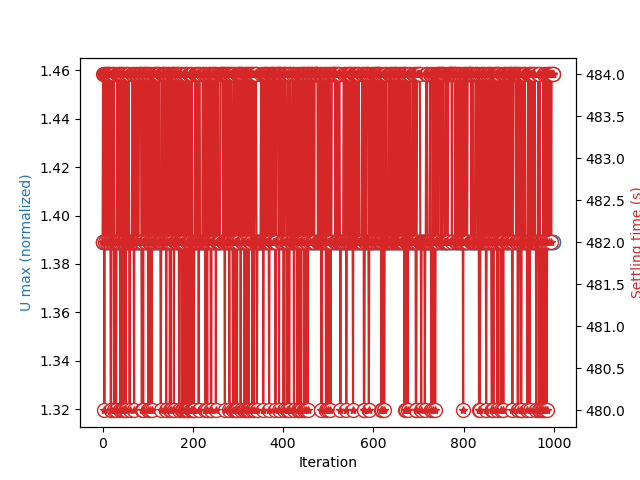

In [78]:
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Iteration') 
ax.set_ylabel('U max (normalized)', color="tab:blue")
ax.plot(u_max_list, color="tab:blue")
ax2 = ax.twinx()
ax2.set_ylabel('Settling time (s)', color="tab:red")
ax2.plot(t_settling_list, color="tab:red")

u_condition = u_max_list<=1.5
t_condition = t_settling_list<800
combined_condition = t_condition & u_condition
ax.plot(np.arange(0,niter,1)[combined_condition], u_max_list[combined_condition], linestyle="none", marker = 'o', ms = 10, mfc = 'w', color="tab:blue")
ax2.plot(np.arange(0,niter,1)[combined_condition], t_settling_list[combined_condition], linestyle="none", marker = 'o', ms = 10, mfc = 'w', color="tab:red")
ax.plot(np.arange(0,niter,1)[u_condition], u_max_list[u_condition], '*', color="tab:blue")
ax2.plot(np.arange(0,niter,1)[t_condition], t_settling_list[t_condition], '*', color="tab:red")

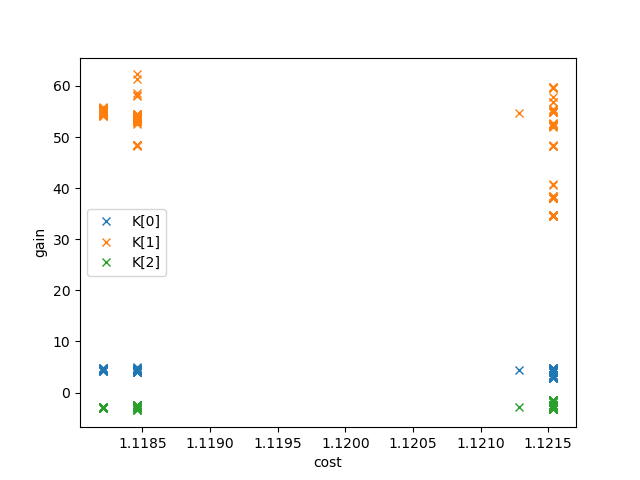

In [79]:
if 'ARX' in file_name:
    fig, ax = plt.subplots()
    labels = []
    ax.set_xlabel('cost') 
    ax.set_ylabel('gain')
    ax.plot(cost, K_list[:,0], 'x', color="tab:blue", label="K[0]")
    ax.plot(cost, K_list[:,1], 'x', color="tab:orange", label="K[1]")
    ax.plot(cost, K_list[:,2], 'x', color="tab:green", label="K[2]")
    ax.legend()
    

In [80]:
if not 'ARX' in file_name:
    score = []
    idx_best_perf = []
    for i, Ki in enumerate(K_list):
        if combined_condition[i]:
            score.append(t_settling_list[i]/800 + u_max_list[i])
            idx_best_perf.append(i)
else:
    score = cost
    

In [81]:
if not 'ARX' in file_name:
    fig, ax = plt.subplots()
    ax.set_xlabel('Normalized settling time') 
    ax.set_ylabel('Normalized command')
    ax.plot(t_settling_list/800, u_max_list, '.')


Text(0.5, 1.0, 'Unit step response, t5% = 484.0s, umax = 1.389')

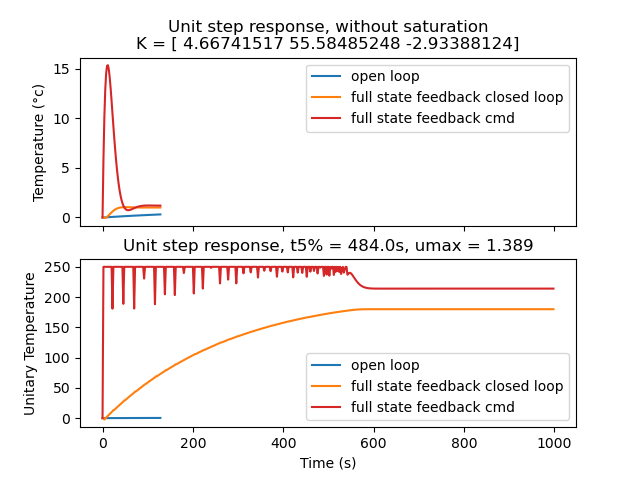

In [82]:
n = np.argmin(score)
if 'ARX' in file_name: 
    N = n
else:
    N = idx_best_perf[n]
t_opt, y_opt, u_opt, y_ol_opt, _ = simulate_full_state_feedback_closed_loop(sysd_3, K_list[N,:].reshape((1,3)), is_integral_action=True)
t_opt_sat, y_opt_sat, u_opt_sat = simulate_full_state_feedback_arx_closed_loop(sysd_3, K_list[N,:].reshape((1,3)), target=180, t_max=1000, cmd_bound=[0,250], is_integral_action=True, is_windup=True)
fig, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)') 
ax[1].set_ylabel('Unitary Temperature')
ax[0].set_ylabel('Temperature (°c)')
ax[0].plot(t_opt, y_ol_opt, color="tab:blue", label='open loop')
ax[0].plot(t_opt, y_opt, color="tab:orange", label='full state feedback closed loop')
ax[0].plot(t_opt, u_opt, color="tab:red", label='full state feedback cmd')
ax[0].legend()
ax[0].set_title("Unit step response, without saturation\nK = {}".format(K_list[N,:]))
ax[1].plot(t_opt, y_ol_opt, color="tab:blue", label='open loop')
ax[1].plot(t_opt_sat, y_opt_sat, color="tab:orange", label='full state feedback closed loop')
ax[1].plot(t_opt_sat, u_opt_sat, color="tab:red", label='full state feedback cmd')
ax[1].legend()
ax[1].set_title("Unit step response, t5% = {:.1f}s, umax = {:.3f}".format(t_settling_list[N], u_max_list[N]))

In [83]:
K_list[N,:]
# array([ 0.20704298,  2.40265026, -0.01561308])

array([ 4.66741517, 55.58485248, -2.93388124])

In [85]:
score[n]
# idx_best_perf[n]

1.1182051282051282

### Top stack full state feedback control

In [96]:
sys_top_list[-1]

TransferFunction(array([0.00380759, 0.00794472]), array([ 1.        , -1.14437971,  0.15697371]), 2)

In [154]:
K_top, Q_top_opt, R_top_opt, cost_top = tune_full_state_feedback_LQR(sys_top_list[-1], cost_function_DLQR_ARX, normalized_max_u)

2024-03-12 18:23:25,601 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=2.93
2024-03-12 18:23:55,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.92573601897629, best pos: [6244.21547741 1205.57848387   22.03807081 8457.18886107]


In [155]:
print("Q_opt: {}".format(Q_top_opt))
print("r_opt: {}".format(R_top_opt))
print("         Found K matrix corrector gain         ")
print("-----------------------------------------------")
print("K_opt: {}".format(K_top))
print("-----------------------------------------------")

Q_opt: [[6244.21547741    0.            0.        ]
 [   0.         1205.57848387    0.        ]
 [   0.            0.           22.03807081]]
r_opt: 8457.188861066927
         Found K matrix corrector gain         
-----------------------------------------------
K_opt: [[-0.5629386   3.61661412 -0.04992806]]
-----------------------------------------------


Text(0.5, 1.0, 'Unit step response, t5% = 352.0s, umax = 2.543')

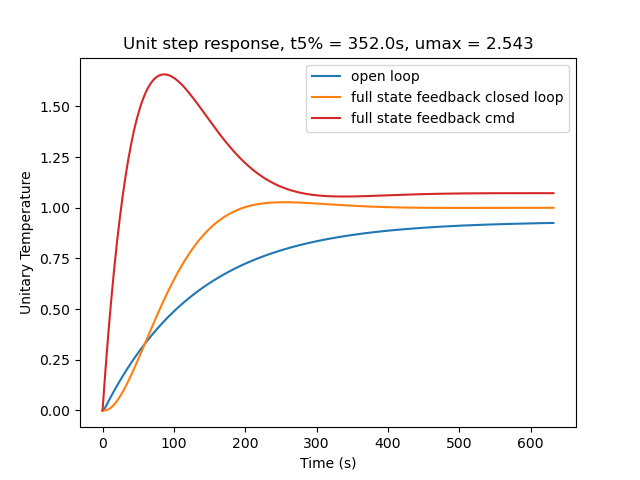

In [156]:
t_top, y_cl_top, u_cl_top, y_ol_top, set_time_top = simulate_full_state_feedback_closed_loop(sys_top_list[-1], K_top, is_integral_action=True)
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Unitary Temperature')
ax.plot(t_top, y_ol_top, color="tab:blue", label='open loop')
ax.plot(t_top, y_cl_top, color="tab:orange", label='full state feedback closed loop')
ax.plot(t_top, u_cl_top, color="tab:red", label='full state feedback cmd')
ax.legend()
ax.set_title("Unit step response, t5% = {:.1f}s, umax = {:.3f}".format(set_time_top, u_max))

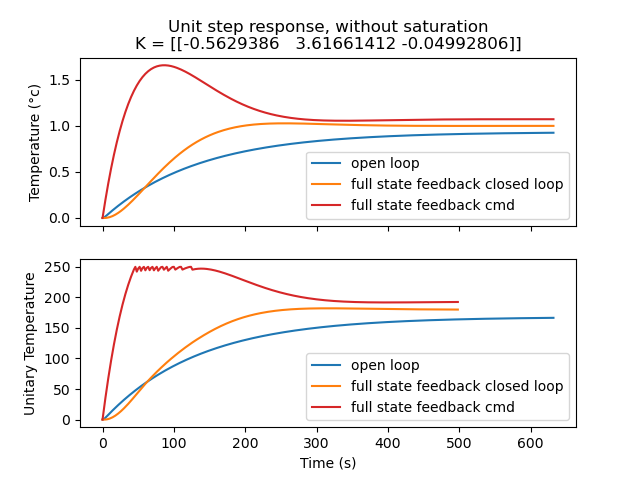

In [158]:
n = np.argmin(score)
if 'ARX' in file_name: 
    N = n
else:
    N = idx_best_perf[n]
t_top_opt, y_top_opt, u_top_opt, y_ol_top_opt, _ = simulate_full_state_feedback_closed_loop(sys_top_list[-1], K_top.reshape((1,3)), is_integral_action=True)
t_top_opt_sat, y_top_opt_sat, u_top_opt_sat = simulate_full_state_feedback_arx_closed_loop(sys_top_list[-1], K_top.reshape((1,3)), target=180, t_max=500, cmd_bound=[0,250], is_integral_action=True, is_windup=True)
fig, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)') 
ax[1].set_ylabel('Unitary Temperature')
ax[0].set_ylabel('Temperature (°c)')
ax[0].plot(t_top_opt, y_ol_top_opt, color="tab:blue", label='open loop')
ax[0].plot(t_top_opt, y_top_opt, color="tab:orange", label='full state feedback closed loop')
ax[0].plot(t_top_opt, u_top_opt, color="tab:red", label='full state feedback cmd')
ax[0].legend()
ax[0].set_title("Unit step response, without saturation\nK = {}".format(K_top))
ax[1].plot(t_top_opt, 180*y_ol_top_opt, color="tab:blue", label='open loop')
ax[1].plot(t_top_opt_sat, y_top_opt_sat, color="tab:orange", label='full state feedback closed loop')
ax[1].plot(t_top_opt_sat, u_top_opt_sat, color="tab:red", label='full state feedback cmd')
ax[1].legend()
# ax[1].set_title("Unit step response, t5% = {:.1f}s, umax = {:.3f}".format(t_settling_list[N], u_max_list[N]))

### Experimental results

In this section, the results of the following full state feedback control are evaluated.

In [86]:
# Reading the data from the PV3 files 
file_path = "data/experimental/24_03_04/15_58_23/heatData/"
bottom_stack_file = "Bottom Heat Controller worker.txt"
bottom_stack_fsf_file = "Full state feedback control - Bottom Heat Controller worker.txt"
data, headers = read_pv3_heatdata_txt(file_path + bottom_stack_file)

t0 = data['Time'][0]
t = (data['Time'] - t0) / 1e3 # conversion to seconds 
setpoint = np.array(data['Target'])
stack_temperature = np.array(data['Stack'])
cart_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]
cart_temperature = []
for cart_name in cart_names:
    cart_temperature.append(data[cart_name])
cart_temperature = np.array(cart_temperature)
cart_cmd = []
for cart_name in cart_names:
    cart_cmd.append(data[cart_name+"_cmd"])
cart_cmd = np.array(cart_cmd)

data, headers = read_pv3_heatdata_txt(file_path + bottom_stack_fsf_file)
fsf_cmd = np.array(data['FSF'])
fsf_t = np.array(data['Time'] - data['Time'][0])/1e3

Text(0.5, 0.98, 'K = [ 0.20704298,  2.40265026, -0.01561308]')

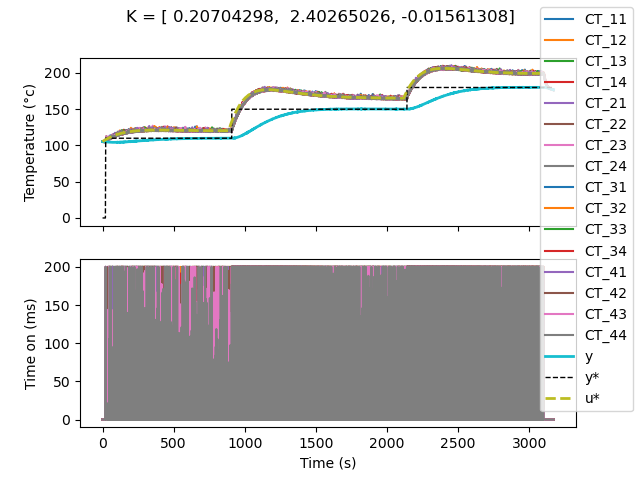

In [87]:
# Plotting the data
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)')
ax[1].set_ylabel('Time on (ms)')
for i, cart_t in enumerate(cart_temperature):
    ax[0].plot(t, cart_t, color=color_list[np.mod(i,8)], label=cart_names[i])
ax[0].plot(t, stack_temperature, color=color_list[9], label="y", linewidth=2)
ax[0].plot(t, setpoint, color="black", linestyle="dashed", label="y*", linewidth=1)
ax[0].plot(fsf_t, fsf_cmd+stack_temperature[0], color=color_list[8], linestyle="dashed", label="u*", linewidth=2)
for i, cart_c in enumerate(cart_cmd):
    ax[1].plot(t, cart_c, color=color_list[np.mod(i,8)])
fig.legend()
fig.suptitle("K = [ 0.20704298,  2.40265026, -0.01561308]")


In [88]:
avg_final_value = np.mean(stack_temperature[(t <= 3100) & (t >= 2900)])
std_final_value = np.std(stack_temperature[(t <= 3100) & (t >= 2900)])
print("Final value {:.3f}°c (STD: {:.3f}°c)".format(avg_final_value, std_final_value))

Final value 180.141°c (STD: 0.044°c)


Comparing against the previous control strategy.

In [89]:
# Reading the data from the PV3 files 
file_path = "data/experimental/24_03_04/17_03_13/heatData/"
bottom_stack_file = "Bottom Heat Controller worker.txt"
data, headers = read_pv3_heatdata_txt(file_path + bottom_stack_file)

t0_old = data['Time'][0]
t_old = (data['Time'] - t0_old) / 1e3 # conversion to seconds 
setpoint_old = np.array(data['Target'])
stack_temperature_old = np.array(data['Stack'])

cart_temperature_old = []
for cart_name in cart_names:
    cart_temperature_old.append(data[cart_name])
cart_temperature_old = np.array(cart_temperature_old)

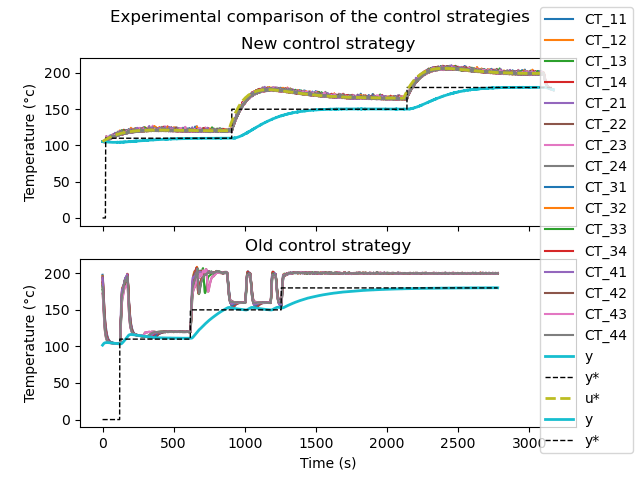

In [90]:
# Plotting the data
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)')
ax[1].set_ylabel('Temperature (°c)')
for i, cart_t in enumerate(cart_temperature):
    ax[0].plot(t, cart_t, color=color_list[np.mod(i,8)], label=cart_names[i])
ax[0].plot(t, stack_temperature, color=color_list[9], label="y", linewidth=2)
ax[0].plot(t, setpoint, color="black", linestyle="dashed", label="y*", linewidth=1)
ax[0].plot(fsf_t, fsf_cmd+stack_temperature[0], color=color_list[8], linestyle="dashed", label="u*", linewidth=2)

for i, cart_t in enumerate(cart_temperature_old):
    ax[1].plot(t_old, cart_t, color=color_list[np.mod(i,8)])
ax[1].plot(t_old, stack_temperature_old, color=color_list[9], label="y", linewidth=2)
ax[1].plot(t_old, setpoint_old, color="black", linestyle="dashed", label="y*", linewidth=1)

ax[0].set_title("New control strategy")
ax[1].set_title("Old control strategy")
fig.suptitle("Experimental comparison of the control strategies")

fig.legend()

In [91]:
avg_final_value = np.mean(stack_temperature_old[(t_old <= 2700) & (t_old >= 2500)])
std_final_value = np.std(stack_temperature_old[(t_old <= 2700) & (t_old >= 2500)])
print("Final value {:.3f}°c (STD: {:.3f}°c)".format(avg_final_value, std_final_value))

Final value 180.051°c (STD: 0.075°c)


The new control strategy offers a more reliable and stable response, but its velocity could be improved.

The full state feedback control with higher gains.

In [92]:
# Reading the data from the PV3 files 
file_path = "data/experimental/24_03_08/14_54_41/heatData/"
bottom_stack_file = "Bottom Heat Controller worker.txt"
bottom_stack_fsf_file = "Full state feedback control - Bottom Heat Controller worker.txt"
data, headers = read_pv3_heatdata_txt(file_path + bottom_stack_file)

t0 = data['Time'][0]
t = (data['Time'] - t0) / 1e3 # conversion to seconds 
setpoint = np.array(data['Target'])
stack_temperature = np.array(data['Stack'])
cart_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]
cart_temperature = []
for cart_name in cart_names:
    cart_temperature.append(data[cart_name])
cart_temperature = np.array(cart_temperature)
cart_cmd = []
for cart_name in cart_names:
    cart_cmd.append(data[cart_name+"_cmd"])
cart_cmd = np.array(cart_cmd)

data, headers = read_pv3_heatdata_txt(file_path + bottom_stack_fsf_file)
fsf_cmd = np.array(data['FSF'])
fsf_t = np.array(data['Time'] - data['Time'][0])/1e3

del data

Text(0.5, 0.98, 'K = [4.66741517, 55.58485248, -2.93388124]')

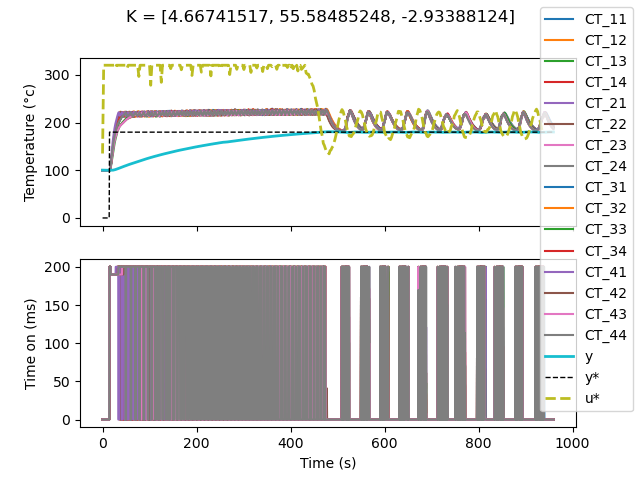

In [93]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)') 
ax[0].set_ylabel('Temperature (°c)')
ax[1].set_ylabel('Time on (ms)')
for i, cart_t in enumerate(cart_temperature):
    ax[0].plot(t, cart_t, color=color_list[np.mod(i,8)], label=cart_names[i])
ax[0].plot(t, stack_temperature, color=color_list[9], label="y", linewidth=2)
ax[0].plot(t, setpoint, color="black", linestyle="dashed", label="y*", linewidth=1)
ax[0].plot(fsf_t, fsf_cmd+stack_temperature[0], color=color_list[8], linestyle="dashed", label="u*", linewidth=2)
for i, cart_c in enumerate(cart_cmd):
    ax[1].plot(t, cart_c, color=color_list[np.mod(i,8)])
fig.legend()
fig.suptitle("K = [4.66741517, 55.58485248, -2.93388124]")

In [94]:
avg_final_value = np.mean(stack_temperature[(t <= 750) & (t >= 550)])
std_final_value = np.std(stack_temperature[(t <= 750) & (t >= 550)])
print("Final value {:.3f}°c (STD: {:.3f}°c)".format(avg_final_value, std_final_value))

Final value 179.993°c (STD: 0.281°c)
